### Load Library

In [345]:
import os
import re
import logging
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment, effects

### Load Dataset

In [346]:
# load data
df = pd.read_csv('data/songs_wav.csv', sep=",")

df.head()

,title,nama_lagu,region,keyword,duration,url,path,wav_path
0,KICIR KICIR | Lagu Daerah Jakarta (Betawi) | D...,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir asal Jakarta,280,https://www.youtube.com/watch?v=LU3YHPgRxQo,datasets/songs/kicir_kicir_lagu_daerah_jakarta...,datasets/wav_songs/kicir_kicir_lagu_daerah_jak...
1,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir asal Jakarta,234,https://www.youtube.com/watch?v=0wTJULU2REc,datasets/songs/kicir_kicir_lagu_dan_tari_nusan...,datasets/wav_songs/kicir_kicir_lagu_dan_tari_n...
2,Kicir Kicir Jakarta,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir asal Jakarta,232,https://www.youtube.com/watch?v=jMynoFKskhc,datasets/songs/kicir_kicir_jakarta.mp3,datasets/wav_songs/kicir_kicir_jakarta.wav
3,Kicir Kicir (Lagu Daerah Betawi),Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir asal Jakarta,237,https://www.youtube.com/watch?v=CcFbCjM2jsM,datasets/songs/kicir_kicir_lagu_daerah_betawi.mp3,datasets/wav_songs/kicir_kicir_lagu_daerah_bet...
4,KARAOKE KICIR KICIR Lagu Daerah Jakarta,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir asal Jakarta,128,https://www.youtube.com/watch?v=nbO8hjzAN20,datasets/songs/karaoke_kicir_kicir_lagu_daerah...,datasets/wav_songs/karaoke_kicir_kicir_lagu_da...


### Data Preprocessing

In [347]:
def sanitize_filename(filename):
    """
    Removes or replaces invalid characters from a filename or folder name.
    """
    return re.sub(r'[<>:"/\\|?*]', '', filename)

def normalized_yt_title(title):
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

def remove_silence(audio, threshold=20):
    return librosa.effects.trim(audio, top_db=threshold)[0]

def normalize_audio(audio):
    return effects.normalize(audio)

split_result = []

def split_songs_to_segments(df, output_base_folder='datasets/30s_segments'):
    for index, row in df.iterrows():
        wav_path = row['wav_path']
        nama_lagu = row['nama_lagu']
        
        os.makedirs(f"{output_base_folder}/{normalized_yt_title(nama_lagu)}", exist_ok=True)
        
        audio = AudioSegment.from_wav(wav_path)
        audio = audio.set_channels(1)
        audio = normalize_audio(audio)
        
        total_duration = len(audio) / 1000
        segment_duration = 30
        num_segments = int(total_duration // segment_duration)
        
        for i in range(num_segments):
            start_time = i * segment_duration * 1000 
            end_time = (i + 1) * segment_duration * 1000
            segment = audio[start_time:end_time]
            
            segment_file = f"{output_base_folder}/{normalized_yt_title(nama_lagu)}/segment_{index}_{i}.wav"
            segment.export(segment_file, format="wav")
            
            split_result.append({
                'title': nama_lagu,
                '30s_path': segment_file
            })
        print(f"Saved {num_segments} segments for {nama_lagu} at: {output_base_folder}/{normalized_yt_title(nama_lagu)}")
        

In [348]:
split_songs_to_segments(df)

Saved 9 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 4 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 8 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 10 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 5 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 8 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 8 segments fo

In [349]:
# save split result to csv
split_result_df = pd.DataFrame(split_result)
split_result_df.to_csv('data/30s_segments.csv', index=False)

### Data Augmentation

In [ ]:
df_res = pd.read_csv('data/30s_segments.csv', sep=",")
df_res.head()

,title,30s_path
0,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav
1,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_1.wav
2,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_2.wav
3,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_3.wav
4,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_4.wav


In [ ]:
import random

def noise(data):
    noise_amp = 0.05 * np.random.uniform() * np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=1.0):
    """
    Stretch the audio by a certain rate
    """
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift(data, sample_rate):
    """
    Shift the pitch by n_steps
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                       sample_rate, n_steps=pitch_change, 
                                       bins_per_octave=bins_per_octave)
    return data

def speedNpitch(data):
    """
    speed and Pitch Tuning.
    """
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

def pad_or_truncate(data, length):
    if len(data) > length:
        return data[:length]
    elif len(data) < length:
        return np.pad(data, (0, length - len(data)), 'constant')
    return data

# def augment_audio(data, sr):
#     augmentations = [
#         lambda x: stretch(x, rate=random.uniform(0.8, 1.2)),
#         lambda x: pitch_shift(x, sr, n_steps=random.randint(-3, 3))
#     ]
    
#     aug = random.choice(augmentations)
#     try:
#         augmented_data = aug(data)
#         augmented_data = pad_or_truncate(augmented_data, len(data))
#     except Exception as e:
#         logging.error(f"Error encountered during augmentation: {e}")
#         return data  # Return the original data if augmentation fails
    
#     return augmented_data

### Feature Extraction

In [415]:
# extract the feature using mfcc
extract_res = []
def mfcc_features(data):
    try:
        for index, row in data.iterrows():
            audio, sample_rate = librosa.load(row['30s_path'])
            mfcc_def = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)

            augmentations = [
                lambda x: noise(x),
                lambda x: speedNpitch(x)
            ]

            extract_res.append({
                'title': row['title'],
                '30s_path': row['30s_path'],
                'mfcc': mfcc_def
            })

            for aug in augmentations:
                augmented_data = aug(audio)
                mfccs = np.mean(librosa.feature.mfcc(y=augmented_data, sr=sample_rate, n_mfcc=40).T, axis=0)
                extract_res.append({
                    'title': row['title'],
                    '30s_path': row['30s_path'],
                    'mfcc': mfccs
                })
        return extract_res
    except Exception as e:
        logging.error(f"Error {e} encountered while parsing file: {data['30s_path']}")
        return None 

def chroma_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path) 
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_processed = np.mean(chroma.T,axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return chroma_processed

def mel_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path) 
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_processed = np.mean(mel.T,axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return mel_processed

def combined_features(file_path):
    mfcc = mfcc_features(file_path)
    chroma = chroma_features(file_path)
    # mel = mel_features(file_path)
    
    return np.concatenate((mfcc, chroma))

In [416]:
features = mfcc_features(df_res)
df_features = pd.DataFrame(features)

In [418]:
df_features.to_csv('data/30s_segments_features.csv', index=False)
df_features.head()

,title,30s_path,mfcc
0,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav,"[-221.54861, 85.78904, 10.051124, 22.60556, 2...."
1,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav,"[-78.50677888230419, 28.9762625862445, 11.0190..."
2,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav,"[-313.171, 53.753452, 4.5513277, 7.820899, 1.6..."
3,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_1.wav,"[-184.57425, 105.25339, 19.904696, 28.026243, ..."
4,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_1.wav,"[-77.34877200717379, 45.093455011304655, 23.81..."


In [420]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 

label_encoder = LabelEncoder()

X = np.array(df_features['mfcc'].tolist())
y = label_encoder.fit_transform(df_features['title'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [421]:
columns = ['class_name', 'class_code']
class_names = pd.DataFrame(columns=columns)
class_names['class_name'] = label_encoder.classes_
class_names['class_code'] = label_encoder.transform(label_encoder.classes_)

class_names.to_csv('model/class_names.csv', index=False)

In [422]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (1456, 40)
X_test shape: (365, 40)


```py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Define the model
model = Sequential()
model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
```

In [423]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, MaxPooling1D, Conv1D, Flatten
from tensorflow.keras.regularizers import l2

# Define the model
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], 1), return_sequences=True,))
model.add(Dropout(0.3))
model.add(LSTM(units=64))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

model.summary()

/home/reiaslite/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 40, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,933 (488.02 KB)

 Trainable params: 124,933 (488.02 KB)

 Non-trainable params: 0 (0.00 B)

In [424]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.2631 - loss: 1.5506 - val_accuracy: 0.3425 - val_loss: 1.4463
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3773 - loss: 1.4094 - val_accuracy: 0.4027 - val_loss: 1.3580
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4296 - loss: 1.2827 - val_accuracy: 0.4219 - val_loss: 1.2727
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4961 - loss: 1.1853 - val_accuracy: 0.5233 - val_loss: 1.1346
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5531 - loss: 1.0951 - val_accuracy: 0.5507 - val_loss: 1.0409
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5844 - loss: 0.9901 - val_accuracy: 0.6411 - val_loss: 0.9104
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6404 - loss: 0.9092 - val_accuracy: 0.6438 - val_loss: 0.9447
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6874 - loss: 0.8380 - val_accuracy: 0

In [425]:
train_hist = pd.DataFrame(history.history)
train_hist['epoch'] = history.epoch
train_hist.tail()

,accuracy,loss,val_accuracy,val_loss,epoch
29,0.924451,0.209279,0.846575,0.499269,29
30,0.936813,0.178286,0.871233,0.437643,30
31,0.947802,0.162213,0.835616,0.581735,31
32,0.949176,0.181027,0.854795,0.525073,32
33,0.942308,0.176279,0.882192,0.415475,33


Test Accuracy: 88.22%


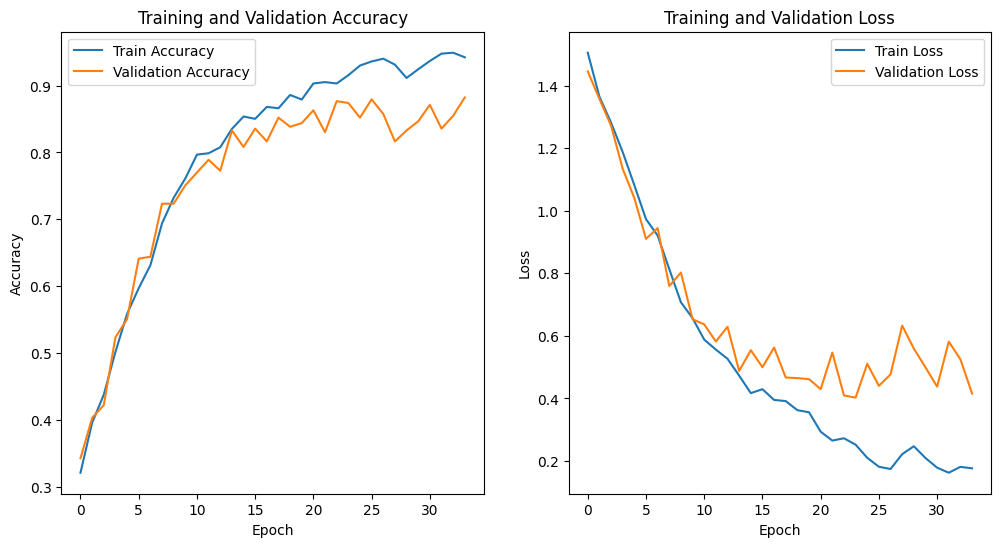

In [426]:
# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc * 100:.2f}%")

# plot the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [427]:
# Get predictions
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
test_accuracy = np.sum(y_pred_classes == y_test) / len(y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Test Accuracy: 88.22%


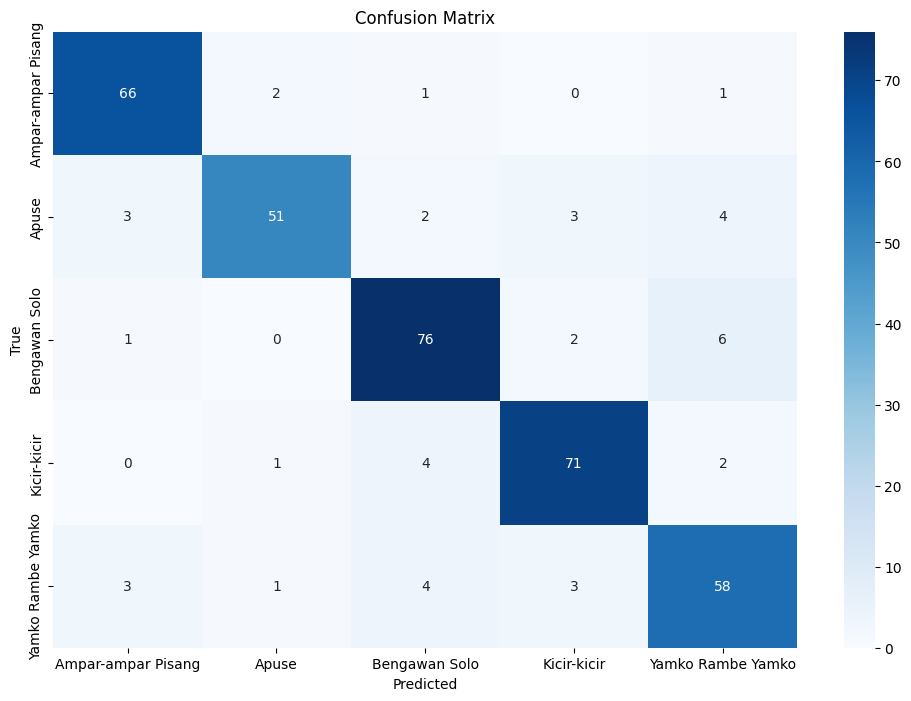

In [428]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

               precision    recall  f1-score   support

Bengawan Solo       0.84      0.90      0.87       179
  Kicir-kicir       0.93      0.92      0.92       193
 Manuk Dadali       0.87      0.90      0.88       137
  Rek Ayo Rek       0.90      0.84      0.87       145
Suwe Ora Jamu       0.94      0.90      0.92       143

     accuracy                           0.89       797
    macro avg       0.90      0.89      0.89       797
 weighted avg       0.90      0.89      0.89       797



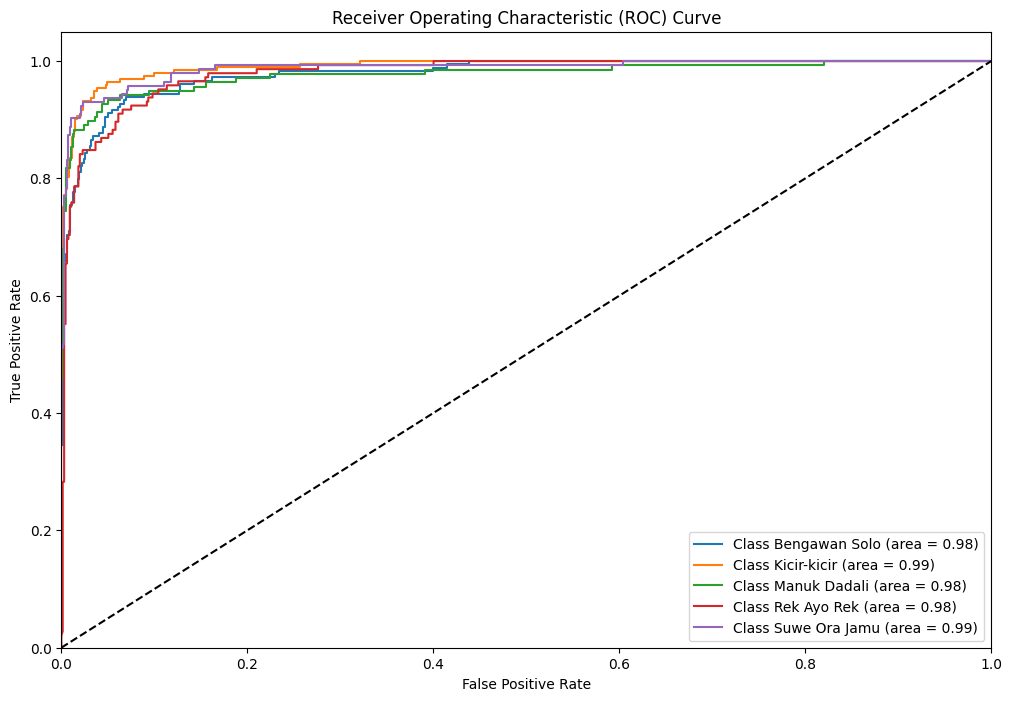

In [338]:
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [435]:
from pydub import AudioSegment
from io import BytesIO
import noisereduce as nr

def convert_to_wav(audio_path):
    audio = AudioSegment.from_file(audio_path)
    audio.set_channels(1)
    wav_io = BytesIO()
    audio.export(wav_io, format="wav")
    wav_io.seek(0)
    return wav_io

# predict
def predict_song_genre(model, file_path):
    # Extract features
    wav = convert_to_wav(file_path)
    audio, sr = librosa.load(wav)
    features = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)
    
    if features is not None:
        # Make prediction
        pred_features = features.reshape(1, -1)
        pred = model.predict(pred_features)
        pred_class = np.argmax(pred)
        
        # Get the predicted class label
        predicted_label = label_encoder.classes_[pred_class]
        
        # Get the predicted class probability
        pred_prob = pred[0][pred_class]
        
        return pred_class, pred_prob, predicted_label
    else:
        return None


In [438]:
# Test the prediction function
file_path = 'datasets/test'

for file in os.listdir(file_path):
    pred_class, pred_prob, pred_label = predict_song_genre(model, f"{file_path}/{file}")
    print(f"File {file}: Predicted Genre: {pred_label} with probability: {pred_prob:.2f}\n")


# pred_class, pred_prob, pred_label = predict_song_genre(model, file_path)
# print(f"Predicted Genre: {pred_label} with probability: {pred_prob:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
File 1AMPAR-PureLagu.mp3: Predicted Genre: Ampar-ampar Pisang with probability: 1.00

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
File Recording (4).m4a: Predicted Genre: Ampar-ampar Pisang with probability: 0.95

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
File Recording (5).m4a: Predicted Genre: Yamko Rambe Yamko with probability: 0.98

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
File 2ampar-ampar.m4a: Predicted Genre: Bengawan Solo with probability: 0.98

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
File Recording (2).m4a: Predicted Genre: Ampar-ampar Pisang with probability: 1.00

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
File Recording.m4a: Predicted Genre: Ampar-ampar Pisang with probability: 0.84

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
File Recording (3).m4a: Predicted Genre: Yamko Rambe Yamko with probability: 0.99



In [341]:
import tensorflowjs as tfjs

# save model
# tf.keras.models.save_model(model, 'model/my_model.h5')
model.save('model.keras')

# load model
# saved_model = tf.keras.models.load_model('best_model.keras')

# # Save the model in TensorFlow.js format
# tfjs.converters.save_keras_model(saved_model, 'model/tfjs_model')

In [342]:
# load model
model = tf.keras.models.load_model('model.keras')